In [1]:
import os
import cv2
import imghdr
import h5py

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,RandomFlip,RandomRotation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model

In [2]:
!unzip -q data.zip -d /content/data

In [3]:

data_dir = '/content/data'  # Update with your actual folder path

# Supported image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Iterate through the image classes and files
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # Read the image using OpenCV
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            # If the image is not of the right extension, remove it
            if tip not in image_exts:
                print('Image not in ext list: {}'.format(image_path))
                os.remove(image_path)  # Remove if invalid image
        except Exception as e:
            # If there's an issue, log it but don't remove the image (optional)
            print('Issue with image: {}'.format(image_path))
            # Uncomment the next line to remove problematic images
            # os.remove(image_path)

Image not in ext list: /content/data/not/vector.svg
Image not in ext list: /content/data/not/vector6.svg
Image not in ext list: /content/data/not/side-view-empty-road-260nw-1440304541.jpg
Image not in ext list: /content/data/not/modern-city-skyline-buildings-empty-260nw-1192283191.jpg
Image not in ext list: /content/data/not/vector3.svg
Image not in ext list: /content/data/not/depositphotos_471781620-stock-photo-city-night-park-penza-russian.jpg
Image not in ext list: /content/data/not/vector4.svg
Image not in ext list: /content/data/not/asphalt-empty-road-city-skyline-260nw-1740094766.jpg
Image not in ext list: /content/data/not/vector8.svg
Image not in ext list: /content/data/not/vector2.svg
Image not in ext list: /content/data/not/asphalt-highway-road-city-skyline-260nw-2477984573.jpg
Image not in ext list: /content/data/not/vector5.svg
Image not in ext list: /content/data/not/vector11.svg
Image not in ext list: /content/data/not/vector9.svg
Image not in ext list: /content/data/not/

In [4]:
data = tf.keras.utils.image_dataset_from_directory('data',image_size =(224,224) )

Found 394 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


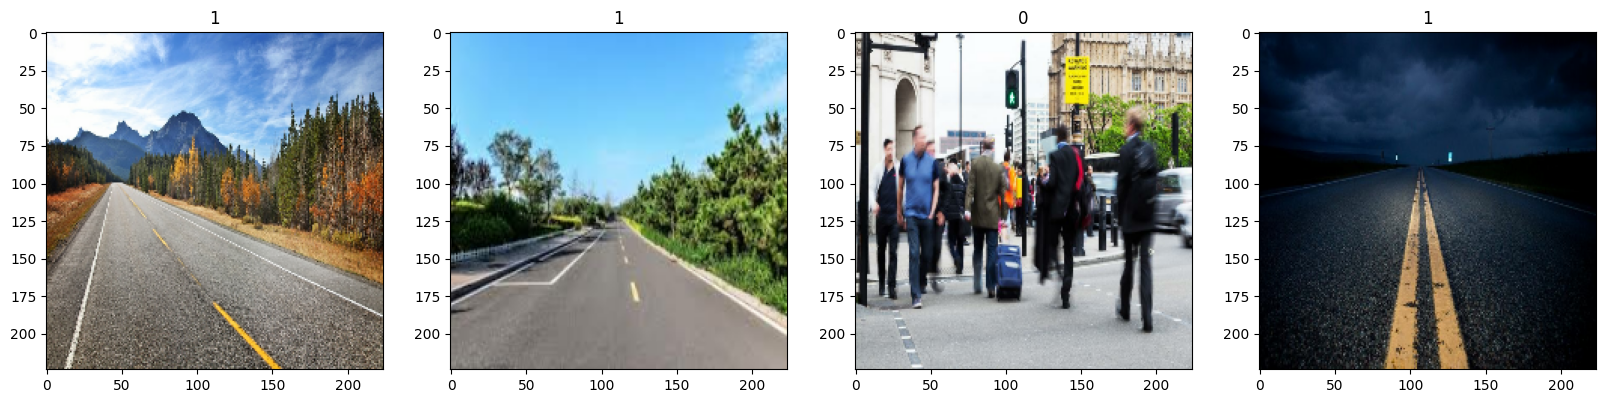

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

In [11]:
def deviding_dataset(dataset):
    images = []
    labels = []

    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert to numpy
        labels.append(label_batch.numpy())

    images = np.vstack(images)
    labels = np.concatenate(labels)
    return images, labels


In [12]:
data = data.map(lambda x, y: (x / 255, y))

In [13]:
data_augmentation = data_augmenter()


In [14]:
augmented_data = data.map(lambda x, y: (data_augmentation(x, training=True), y))

In [15]:
train_size = int(len(augmented_data) * 0.7)
test_size = int(len(augmented_data) * 0.3)

In [16]:
train = augmented_data.take(train_size)
test = augmented_data.skip(train_size).take(test_size)

In [17]:
train_images, train_labels = deviding_dataset(train)
test_images, test_labels = deviding_dataset(test)

In [18]:
# with h5py.File('augmented_datasets.h5', 'w') as hf:
#     hf.create_dataset('train_images', data=train_images)
#     hf.create_dataset('train_labels', data=train_labels)
#     hf.create_dataset('test_images', data=test_images)
#     hf.create_dataset('test_labels', data=test_labels)

In [19]:
train_images.shape

(288, 224, 224, 3)

In [20]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
mobilenetv2.trainable = False

# Add new layers on top of the base model
x = mobilenetv2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Adjust the number of classes

# Create the final model
model_mobilenet = tf.keras.Model(inputs=mobilenetv2.input, outputs=x)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
model_mobilenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [23]:
model_mobilenet.fit(train_images,train_labels, epochs=5)


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6272 - loss: 1.1973
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9743 - loss: 0.0605
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9965 - loss: 0.0158
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9979 - loss: 0.0057
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0044


In [24]:
model_mobilenet.evaluate(test_images,test_labels)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9948 - loss: 0.0148


[0.02035749889910221, 0.9895833134651184]

In [25]:
def predict_and_display(model, test_images, test_labels, num_samples=5):
    # Make predictions
    predictions = model.predict(test_images)

    # Choose random samples to display
    indices = np.random.choice(range(len(test_images)), num_samples, replace=False)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

    for i, idx in enumerate(indices):
        # Get the image and its prediction
        image = test_images[idx]
        pred = predictions[idx][0]
        true_label = test_labels[idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')

        # Set the title based on the prediction
        if pred > 0.5:
            pred_text = "Road is clear"
            color = 'green'
        else:
            pred_text = "People are crossing"
            color = 'red'

        # Display prediction and true label
        axes[i].set_title(f"Pred: {pred_text}\nTrue: {'Clear' if true_label == 1 else 'Crossing'}",
                          color=color)

    plt.tight_layout()
    plt.show()

    # Print overall accuracy
    binary_predictions = (predictions > 0.5).astype(int)
    accuracy = np.mean(binary_predictions.flatten() == test_labels)
    print(f"Overall Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


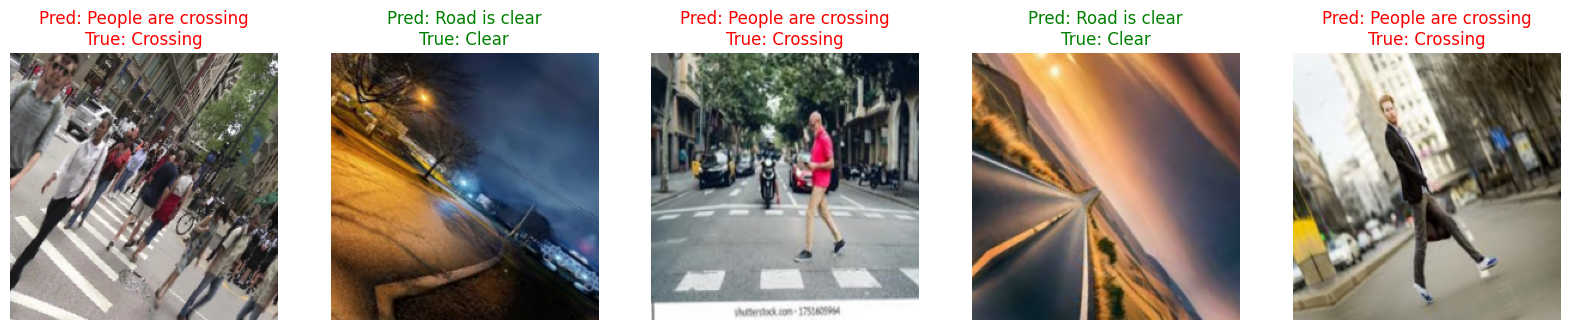

In [37]:
predict_and_display(model_mobilenet,test_images, test_labels, num_samples=5)

In [35]:
model_mobilenet.save("mobilenetv2.keras")